In [27]:
import xyzpy as xyz
import combo_dynamics
from combo_dynamics import *
from math import pi
import quimb.tensor as qtn

import numpy as np
import os
from quimb.tensor.circuit import *
from matplotlib import pyplot as plt

# set single thread
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
# specify which gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# SimpleUpdate
D_init = 2
j = (1, 1, 1)
g = 0
Lx = 4
Ly = 2
tau_list = [0.5, 0.1, 0.03, 0.01, 5e-3]
n_steps = 200
# import torch

# if torch.cuda.is_available():
#     device = 'cuda'
# else:
#     device = 'cpu'
H2 = qu.ham_heis(n=2, j=j)
if g != 0:
    H1 = qu.ham_heis(n=1, b=(0, 0, g))
    ham = qtn.LocalHam2D(Lx, Ly, H2=H2, H1=H1)
else:
    ham = qtn.LocalHam2D(Lx, Ly, H2=H2)


def fill_fn(shape):
    array = np.zeros(
        shape
    )  # except for the first element being 1, all other elements are 0
    # shape is a tuple of unknown length, so we use *shape to unpack it
    zeros = np.zeros(len(shape))
    array[tuple(zeros.astype(int))] = 1
    return array


ordering = ham.get_auto_ordering('random_sequential')

In [19]:
# use pickle to save ordering and load it
import pickle

with open('./ordering.pkl', 'wb') as f:
    pickle.dump(ordering, f)

new_ordering = pickle.load(open('./ordering.pkl', 'rb'))

In [28]:
its_list = []
energy_list = []
D_list = [16]
for D in D_list:
    print('D:', D)
    init_peps = qtn.PEPS.rand(Lx, Ly, bond_dim=D_init, seed=666)

    # ham.apply_to_arrays(to_backend)
    # init_peps.apply_to_arrays(to_backend)
    su = qtn.SimpleUpdate_exact_energy(
        init_peps,
        ham,
        chi=128,  # boundary contraction bond dim for computing energy
        compute_energy_every=40,
        compute_energy_per_site=True,
        keep_best=True,
        second_order_reflect=False,
        ordering=new_ordering,
        D=D,
    )

    for tau in tau_list:
        print(su.ordering)
        su.evolve(n_steps, tau=tau)

    its_list.append(su.its)
    energy_list.append(su.energies)


D: 16
(((0, 0), (0, 1)), ((2, 0), (2, 1)), ((1, 0), (1, 1)), ((3, 0), (3, 1)), ((0, 0), (1, 0)), ((2, 1), (3, 1)), ((2, 0), (3, 0)), ((0, 1), (1, 1)), ((1, 1), (2, 1)), ((1, 0), (2, 0)))


n=200, tau=0.5000, energy~-0.514544: 100%|##########| 200/200 [00:03<00:00, 59.63it/s]


(((0, 0), (0, 1)), ((2, 0), (2, 1)), ((1, 0), (1, 1)), ((3, 0), (3, 1)), ((0, 0), (1, 0)), ((2, 1), (3, 1)), ((2, 0), (3, 0)), ((0, 1), (1, 1)), ((1, 1), (2, 1)), ((1, 0), (2, 0)))


n=400, tau=0.1000, energy~-0.535070: 100%|##########| 200/200 [00:03<00:00, 64.35it/s]


(((0, 0), (0, 1)), ((2, 0), (2, 1)), ((1, 0), (1, 1)), ((3, 0), (3, 1)), ((0, 0), (1, 0)), ((2, 1), (3, 1)), ((2, 0), (3, 0)), ((0, 1), (1, 1)), ((1, 1), (2, 1)), ((1, 0), (2, 0)))


n=600, tau=0.0300, energy~-0.536020: 100%|##########| 200/200 [00:02<00:00, 66.69it/s]


(((0, 0), (0, 1)), ((2, 0), (2, 1)), ((1, 0), (1, 1)), ((3, 0), (3, 1)), ((0, 0), (1, 0)), ((2, 1), (3, 1)), ((2, 0), (3, 0)), ((0, 1), (1, 1)), ((1, 1), (2, 1)), ((1, 0), (2, 0)))


n=800, tau=0.0100, energy~-0.536116: 100%|##########| 200/200 [00:03<00:00, 56.42it/s]


(((0, 0), (0, 1)), ((2, 0), (2, 1)), ((1, 0), (1, 1)), ((3, 0), (3, 1)), ((0, 0), (1, 0)), ((2, 1), (3, 1)), ((2, 0), (3, 0)), ((0, 1), (1, 1)), ((1, 1), (2, 1)), ((1, 0), (2, 0)))


n=1000, tau=0.0050, energy~-0.536127: 100%|##########| 200/200 [00:02<00:00, 68.65it/s]


In [13]:
# test_state = su.state
test_state = qtn.PEPS.rand(Lx, Ly, bond_dim=16)
print(test_state.contract())
# E = test_state.compute_local_expectation_exact(ham.terms) / (Lx * Ly)
# print(E)

Tensor(shape=(2, 2, 2, 2, 2, 2, 2, 2), inds=('k0,0', 'k0,1', 'k1,0', 'k1,1', 'k2,0', 'k2,1', 'k3,0', 'k3,1'), tags=oset(['I0,0', 'X0', 'Y0', 'I0,1', 'Y1', 'I1,0', 'X1', 'I1,1', 'I2,0', 'X2', 'I2,1', 'I3,0', 'X3', 'I3,1']), backend='numpy', dtype='float64')


In [6]:
its_list = np.array(its_list)
energy_list = np.array(energy_list)
# print(its_list)
# print(energy_list)
np.save('./SU_Heisenberg/4x4/its_list.npy', its_list)
np.save('./SU_Heisenberg/4x4/energy_list.npy', energy_list)

In [3]:
import quimb as qu

energy_exact = qu.groundenergy(qu.ham_heis_2D(Lx, Ly, sparse=True)) / (Lx * Ly)
energy_exact

-0.5366333070821335

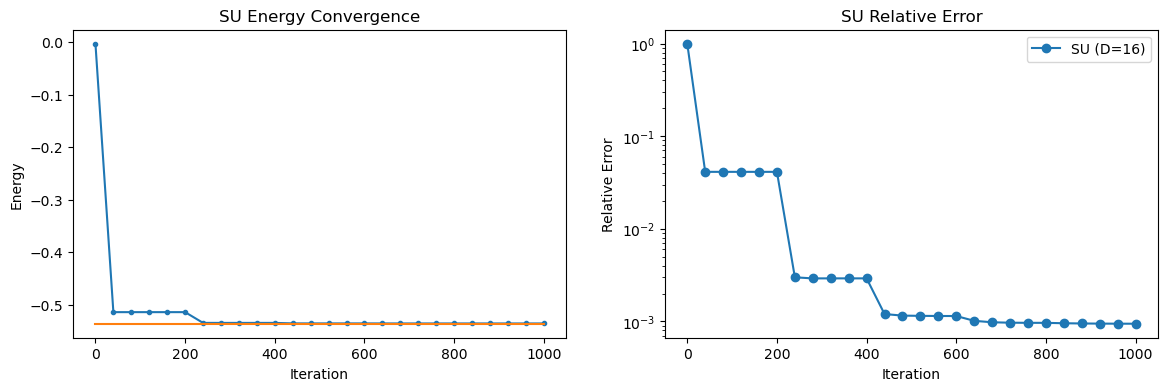

In [29]:
its = np.array(su.its)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for D in D_list:
    ax[0].plot(its_list[D_list.index(D)],
               energy_list[D_list.index(D)],
               '.-',
               label='SU (D=%d)' % D)
    relative_error = np.abs(energy_list[D_list.index(D)] -
                            energy_exact) / np.abs(energy_exact)
    # ax[1].plot(its_list[D_list.index(D)], energy_exact * np.ones_like(its_list[D_list.index(D)]), '--', label='Exact')
    ax[1].plot(its_list[D_list.index(D)],
               relative_error,
               'o-',
               label='SU (D=%d)' % D)
ax[0].plot(its, energy_exact * np.ones_like(its), '-', label='Exact')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Energy')
ax[0].set_title('SU Energy Convergence')
# ax[0].set_yscale('log')
# ax[1].plot(its, relative_error, 'o-', label='SU (D=%d)' % D)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Relative Error')
ax[1].set_title('SU Relative Error')
ax[1].set_yscale('log')
plt.legend()
plt.show()

### Plot the SU energy - 1/D relation

In [ ]:
energy_list = np.load('./SU_Heisenberg/4x2/energy_list.npy')
its_list = np.load('./SU_Heisenberg/4x2/its_list.npy')


In [4]:
# use the best SU state as the starting point for FU
psi0 = su.best['state'].copy()


def to_backend(x):
    import torch
    return torch.tensor(x, dtype=torch.float64)


psi0.apply_to_arrays(to_backend)
ham.apply_to_arrays(to_backend)

fu = qtn.FullUpdate(
    psi0=psi0,
    ham=ham,
    # chi again is the boundary contraction max_bond
    # now used for the envs as well as any energy calc
    chi=32,
    # we thus can cheaply compute the energy at every step
    compute_energy_every=5,
    compute_energy_per_site=True,
    keep_best=True,
    D=D,
)

In [5]:
fu.evolve(100, tau=0.01)

n=100, tau=0.0100, energy~-0.535366: 100%|##########| 100/100 [00:16<00:00,  6.20it/s]


In [6]:
fu.evolve(100, tau=0.01)

n=200, tau=0.0100, energy~-0.536086: 100%|##########| 100/100 [00:21<00:00,  4.76it/s]


In [7]:
fu.evolve(100, tau=0.01)

n=300, tau=0.0100, energy~-0.534720: 100%|##########| 100/100 [00:22<00:00,  4.52it/s]


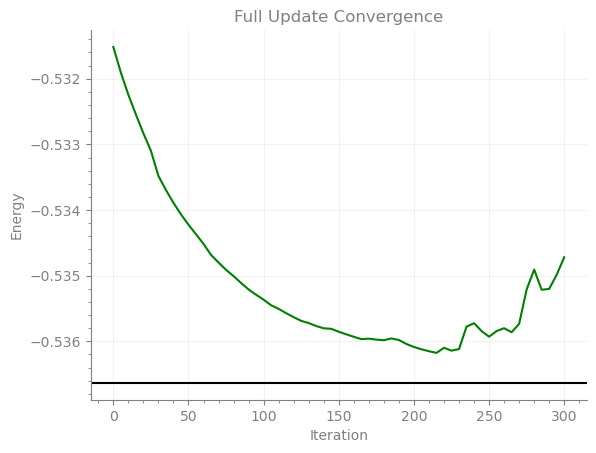

In [8]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plt.plot(fu.its, fu.energies, color='green')
    plt.axhline(energy_exact, color='black')
    plt.title('Full Update Convergence')
    plt.ylabel('Energy')
    plt.xlabel('Iteration')

In [ ]:
Lx = 4
Ly = 2
psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=4)
ham = qtn.LocalHam2D(Lx, Ly, H2=qu.ham_heis(2))


def loss(psi, terms):
    # the following functions simply scale the various tensors
    #     for the sake of numerical stability
    psi.balance_bonds_()
    psi.equalize_norms_(1.0)

    # then we just compute the energy of all the terms
    return psi.compute_local_expectation(
        terms, max_bond=32, cutoff=0.0, normalized=True) / (Lx * Ly)


# def from_torch(x):
#     return x.detach().cpu().numpy()
# psi0 = fu.best['state'].copy()
# psi0.apply_to_arrays(from_torch)


In [ ]:
tnopt = qtn.TNOptimizer(
    # initial TN to optimize
    psi0,
    # the function to minimize
    loss_fn=loss,
    # constant TNs, tensors, arrays
    loss_constants={'terms': ham.terms},
    # the library that computes the gradient
    autodiff_backend='torch',
    # the scipy optimizer that makes use of the gradient
    optimizer='L-BFGS-B',
)